## Data Preparation

In [1]:
import scanpy as sc
import mnmstpy as mnmst
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
import src.logger as l
warnings.filterwarnings("ignore")

In [2]:
section_id = "151675"
input_dir = os.path.join('../data',section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')

sc.pp.filter_genes(adata, min_counts=10)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
hvg_filter = adata.var['highly_variable']

sc.pp.normalize_total(adata, inplace=True)
# sc.pp.log1p(adata)
adata = adata[:, hvg_filter]
# sc.pp.scale(adata, zero_center=False, max_value=10)
display(adata)

View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

#### Following [Squidpy], value of $K$ is set to 6 for Visium dataset

In [3]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


### stACN uses the top 50 PCs of enhanced data by default

In [4]:
sc.pp.pca(enhanced_adata, n_comps=100)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x

### Load the Ground Truth data

In [5]:
Ann_df = pd.read_csv(os.path.join('../data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [6]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

# Execute stACN

In [7]:
import torch
from stacn import st_acn_gpu, st_acn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Z_all =  st_acn_gpu(expression, cell_spatial, lamb=0.001, dim= 200, device=device)

[st_acn] Iter 49: err=['1.9265e-05', '1.6215e-05'], max_err=3.8962e-04, thresh=1.0000e-05: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [8]:
Z_all = Z_all.cpu().detach().numpy()

# Clustering

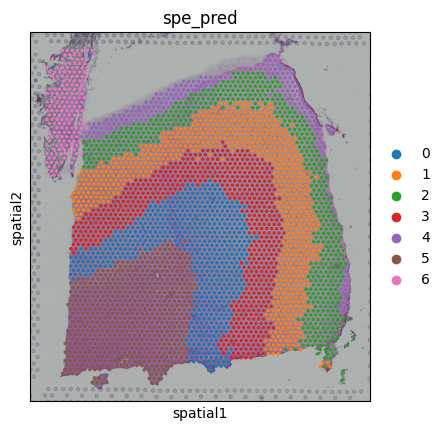

In [9]:
from sklearn.cluster import SpectralClustering

n_clusters = 7
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(Z_all)

adata.obs['spe_pred'] = labels
adata.obs["spe_pred"] = adata.obs["spe_pred"].astype('int')
adata.obs['spe_pred'] = adata.obs['spe_pred'].astype('category')
sc.pl.spatial(adata, color=['spe_pred'])

In [10]:
from src.utils import refine

weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['spe_pred'].tolist(), dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['spe_pred'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
stACN_ari, refine_ari

(0.6333860464097548, 0.639720928400513)

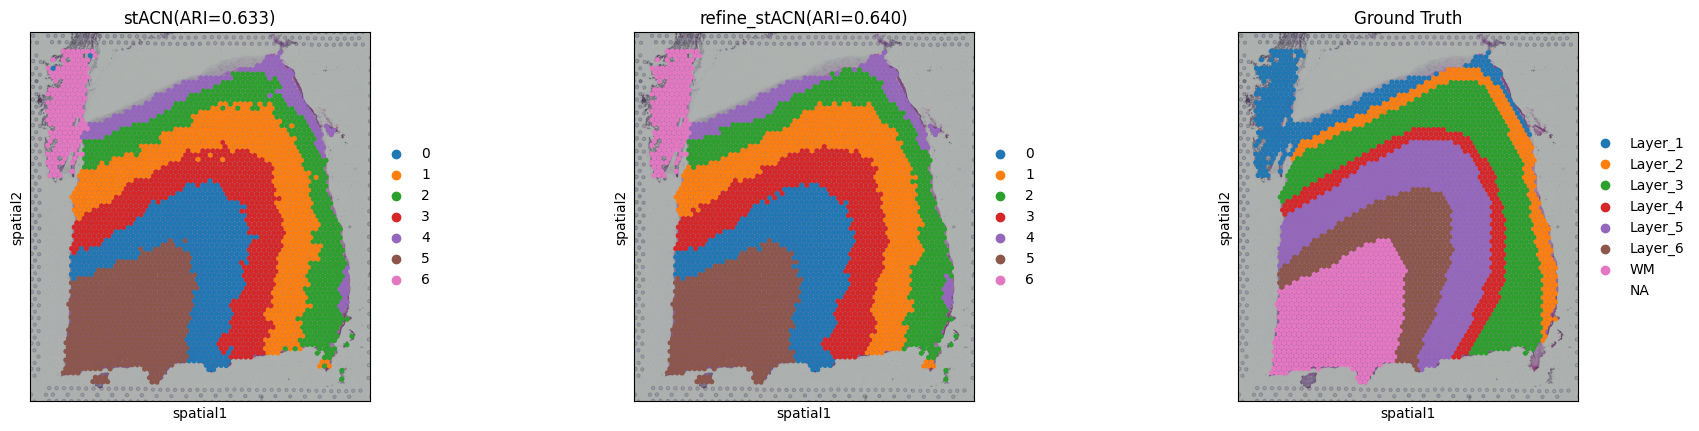

In [11]:
sc.pl.spatial(adata, color=['spe_pred', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=1.5)

In [12]:
### Display the denoised gene expression

In [13]:
raw_adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
sc.pp.filter_genes(raw_adata, min_counts=10)

raw_adata.layers['denoised'] = Z_all @ raw_adata.X 

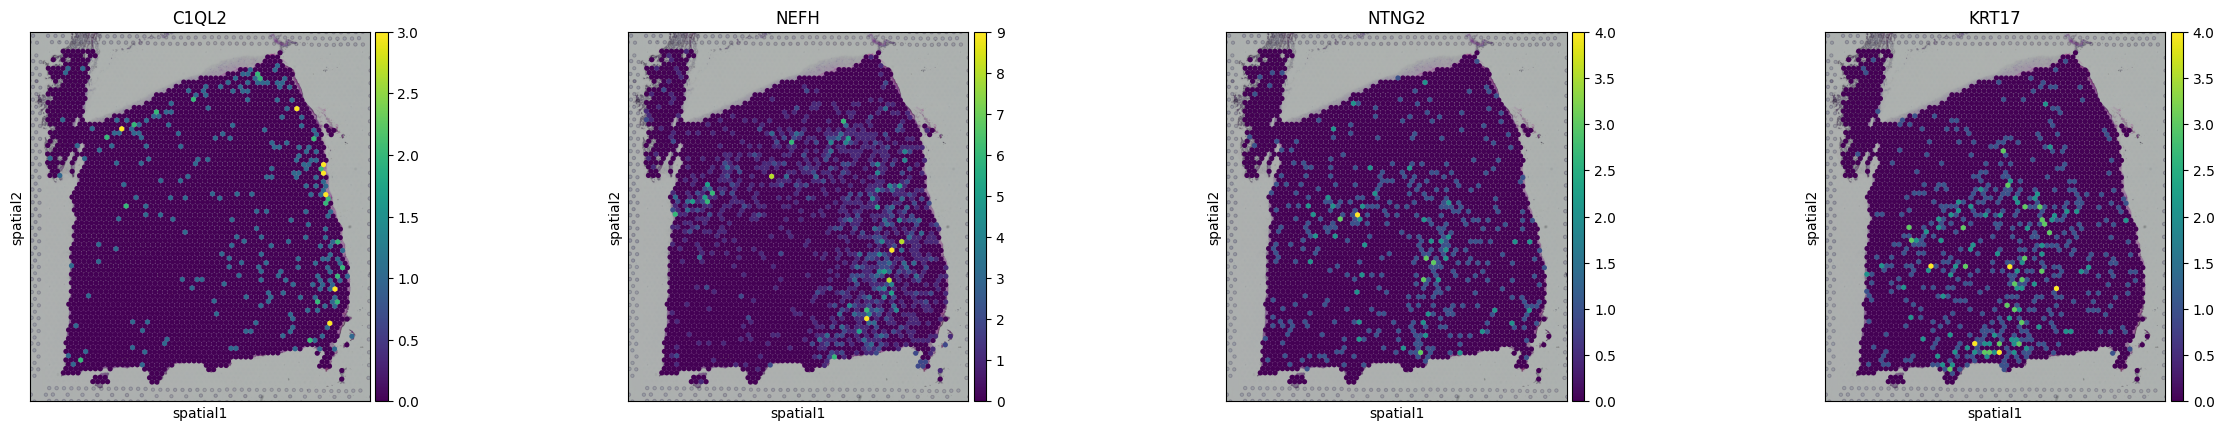

In [14]:
# display the raw gene expression
sc.pl.spatial(raw_adata, color=['C1QL2', 'NEFH', 'NTNG2', 'KRT17'], size=1.5)

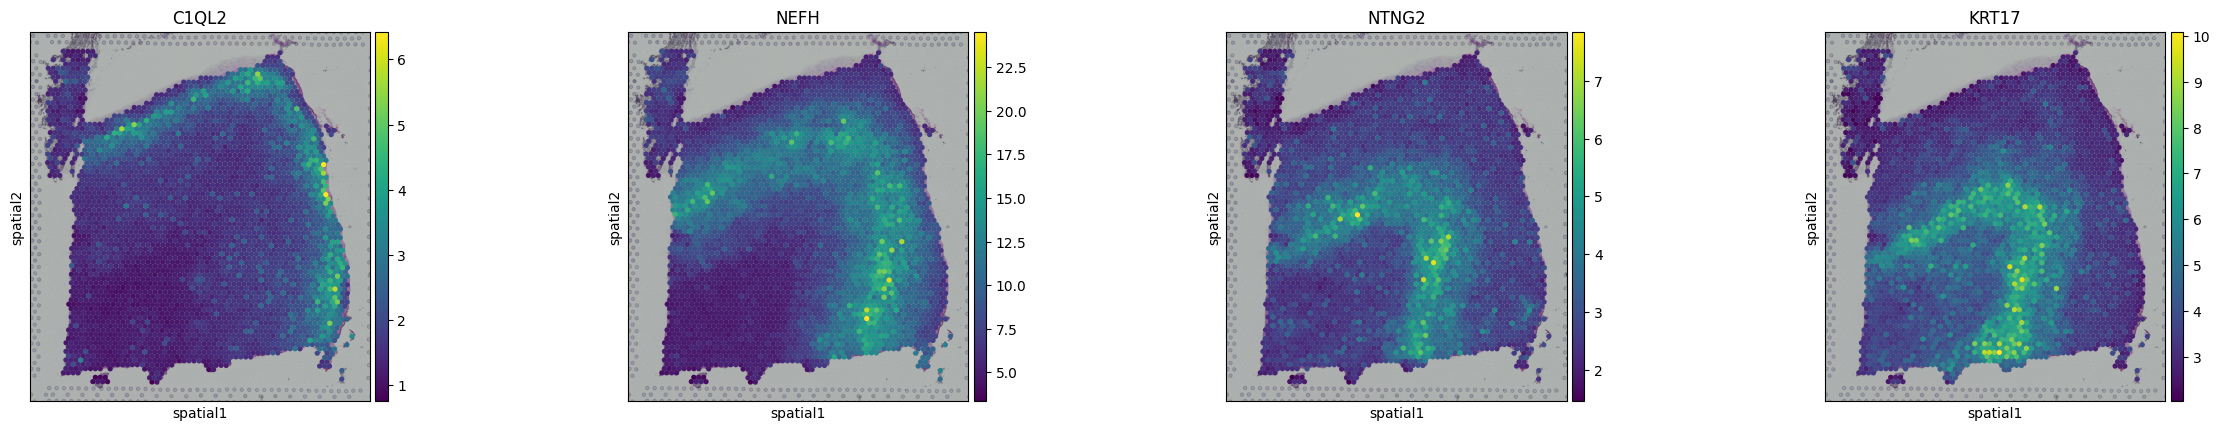

In [15]:
# display the denoised gene expression
sc.pl.spatial(raw_adata, color=['C1QL2', 'NEFH', 'NTNG2', 'KRT17'], layer='denoised', size=1.5)